# Unzip

In [ ]:
!unzip /content/drive/MyDrive/flower17.zip

Archive:  /content/drive/MyDrive/flower17.zip
replace test/6/image_07182.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test/6/image_07182.jpg  
  inflating: test/6/image_07198.jpg  
  inflating: test/6/image_07185.jpg  
  inflating: test/6/image_07173.jpg  
  inflating: test/6/image_07191.jpg  
  inflating: test/6/image_08108.jpg  
  inflating: test/6/image_07199.jpg  
  inflating: test/6/image_07181.jpg  
  inflating: test/6/image_08106.jpg  
  inflating: test/12/image_03994.jpg  
  inflating: test/12/image_04023.jpg  
  inflating: test/12/image_04077.jpg  
  inflating: test/12/image_04016.jpg  
  inflating: test/12/image_04014.jpg  
  inflating: test/12/image_04059.jpg  
  inflating: test/12/image_04052.jpg  
  inflating: test/12/image_04012.jpg  
  inflating: test/12/image_03996.jpg  
  inflating: test/3/image_06641.jpg  
  inflating: test/3/image_06634.jpg  
  inflating: test/14/image_06052.jpg  
  inflating: test/14/image_06091.jpg  
  inflating: test/14/image_06083.jp

# Import Library


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
import torch.utils.data as data
from torchvision import datasets, models, transforms
import time
import json
import copy
import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt


# Load Data

In [ ]:
data_dir = '/flowers'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'
valid_dir = data_dir +'/valid'

### Data Transforms

In [ ]:
data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomRotation(45),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

### Data Loader


In [ ]:
image_loader = {x : datasets.ImageFolder(root = x , transform=data_transforms[x])
                for x in list(data_transforms.keys())
                }

In [ ]:
data_loader = {x : data.DataLoader(image_loader[x],batch_size=4,shuffle=True,num_workers=2)
                                   for x in list(image_loader.keys())
}

In [ ]:
dataset_sizes = {
        x: len(data_loader[x].dataset) 
        for x in list(image_loader.keys())
    }

In [ ]:
class_names = image_loader['train'].classes

In [ ]:
dataset_sizes

{'train': 784, 'valid': 89, 'test': 95}

# Labeling

In [ ]:
with open ("/content/drive/MyDrive/Colab Notebooks/label_name.json", "r") as f :
  label_name =json.load(f)

In [ ]:
# changing categories to their actual names 
for i in range(0,len(class_names)):
    class_names[i] = label_name.get(class_names[i])

In [ ]:
class_names

['pink primrose',
 'globe thistle',
 'snapdragon',
 "colt's foot",
 'king protea',
 'spear thistle',
 'yellow iris',
 'globe-flower',
 'purple coneflower',
 'hard-leaved pocket orchid',
 'canterbury bells',
 'sweet pea',
 'english marigold',
 'tiger lily',
 'moon orchid',
 'bird of paradise',
 'monkshood']

# Visualize data

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

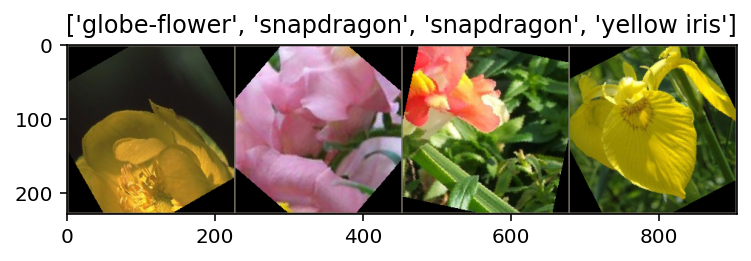

In [ ]:
inputs, classes = next(iter(data_loader['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Load transfer learning


In [ ]:
model_resnet = models.resnet34(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_vgg = models.vgg16(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_mobilev2 = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Analisi Arsitekture model


In [ ]:
!pip install -q torchinfo
from torchinfo import summary

In [ ]:
# resnet 34
summary(model=model_resnet, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [ ]:
# vgnet16
summary(model=model_vgg, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   1,792                True
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   36,928               True
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  73,856               True
│    └─ReLU (6)     

In [ ]:
# mobilenet_2
summary(model=model_mobilev2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MobileNetV2 (MobileNetV2)                     [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)               [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                   [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─ReLU6 (2)                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─InvertedResidual (1)                   [32, 32, 112, 112]   [32, 16, 112, 112]   --                   True
│    │    └─Sequential (conv)                 [32, 32, 112, 112]   [32, 16, 112, 112]

# Frezze and replace backbone


1. Resnet


In [ ]:
# frezee parameters model resnet
for param in model_resnet.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_resnet.fc = nn.Linear(in_features=model_resnet.fc.in_features, 
                    out_features=output_shape,
                    bias=True)

In [ ]:
# look the summary
# resnet 34
summary(model=model_resnet, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 17]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

2. Vgg Net


In [ ]:
# freeze
for param in model_vgg.features.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
num_features = model_vgg.classifier[6].in_features
features = list(model_vgg.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
model_vgg.classifier = nn.Sequential(*features) # Replace the model classifier

In [ ]:
# vgnet16
summary(model=model_vgg, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 17]             --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (

# Mobile net v2


In [ ]:
# freeze
for param in model_mobilev2.features.parameters():
    param.requires_grad = False

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
num_features = model_mobilev2.classifier[1].in_features
features = list(model_mobilev2.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
model_mobilev2.classifier = nn.Sequential(*features) # Replace the model classifier

In [ ]:
# mobilev2
summary(model=model_mobilev2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MobileNetV2 (MobileNetV2)                     [32, 3, 224, 224]    [32, 17]             --                   Partial
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)               [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                   [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─ReLU6 (2)                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─InvertedResidual (1)                   [32, 32, 112, 112]   [32, 16, 112, 112]   --                   False
│    │    └─Sequential (conv)                 [32, 32, 112, 112]   [32, 16, 1

# Training Model

In [ ]:
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_resnet = model_resnet.cuda()
    model_vgg = model_vgg.cuda()
    model_mobilev2 = model_mobilev2.cuda()

In [ ]:
# Multiclassification 
criterion = nn.CrossEntropyLoss() # defining loss function

# optimisasi used the nestrov by SGD
optimizer_resnet = optim.SGD(model_resnet.parameters(), lr=1e-2, momentum=9e-1)
optimizer_vgg = optim.SGD(model_vgg.parameters(),lr=1e-2,momentum=9e-1)
optimizer_mobilev2 = optim.SGD(model_mobilev2.parameters(),lr=1e-2,momentum=9e-1)

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in data_loader[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                # saving a checkpoint to use for next time to save time used in training from scratch
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()
    

    for i, data in enumerate(data_loader['valid']):
        inputs, labels = data
        #print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        #print(outputs)
        _, preds = torch.max(outputs.data, 1)
        #print(preds)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

1. Train Resnet


In [ ]:
summary_resnet = train_model(model_resnet, criterion, optimizer_resnet,num_epochs=20)

Epoch 0/19
----------
train Loss: 0.5175 Acc: 0.7717
valid Loss: 0.1314 Acc: 0.9101

Epoch 1/19
----------
train Loss: 0.4951 Acc: 0.7755
valid Loss: 0.1210 Acc: 0.9326

Epoch 2/19
----------
train Loss: 0.4640 Acc: 0.7895
valid Loss: 0.1351 Acc: 0.8876

Epoch 3/19
----------
train Loss: 0.5352 Acc: 0.7640
valid Loss: 0.2807 Acc: 0.8876

Epoch 4/19
----------
train Loss: 0.5681 Acc: 0.7526
valid Loss: 0.3287 Acc: 0.8652

Epoch 5/19
----------
train Loss: 0.6216 Acc: 0.7640
valid Loss: 0.1789 Acc: 0.9326

Epoch 6/19
----------
train Loss: 0.5282 Acc: 0.7793
valid Loss: 0.2528 Acc: 0.8989

Epoch 7/19
----------
train Loss: 0.5555 Acc: 0.7806
valid Loss: 0.5194 Acc: 0.8315

Epoch 8/19
----------
train Loss: 0.5198 Acc: 0.7895
valid Loss: 0.2091 Acc: 0.9101

Epoch 9/19
----------
train Loss: 0.5268 Acc: 0.7755
valid Loss: 0.2397 Acc: 0.9326

Epoch 10/19
----------
train Loss: 0.5093 Acc: 0.7768
valid Loss: 0.0907 Acc: 0.9663

Epoch 11/19
----------
train Loss: 0.5406 Acc: 0.7844
valid Loss

In [ ]:
summary_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 2. Train vgg


In [ ]:
summary_vgg = train_model(model_vgg, criterion, optimizer_vgg,num_epochs=20)

Epoch 0/19
----------
train Loss: nan Acc: 0.0344
valid Loss: nan Acc: 0.0899

Epoch 1/19
----------
train Loss: nan Acc: 0.0344
valid Loss: nan Acc: 0.0899

Epoch 2/19
----------
train Loss: nan Acc: 0.0344
valid Loss: nan Acc: 0.0899

Epoch 3/19
----------
train Loss: nan Acc: 0.0344
valid Loss: nan Acc: 0.0899

Epoch 4/19
----------
train Loss: nan Acc: 0.0344
valid Loss: nan Acc: 0.0899

Epoch 5/19
----------
train Loss: nan Acc: 0.0344
valid Loss: nan Acc: 0.0899

Epoch 6/19
----------
train Loss: nan Acc: 0.0344
valid Loss: nan Acc: 0.0899

Epoch 7/19
----------
train Loss: nan Acc: 0.0344
valid Loss: nan Acc: 0.0899

Epoch 8/19
----------
train Loss: nan Acc: 0.0344
valid Loss: nan Acc: 0.0899

Epoch 9/19
----------
train Loss: nan Acc: 0.0344
valid Loss: nan Acc: 0.0899

Epoch 10/19
----------
train Loss: nan Acc: 0.0344
valid Loss: nan Acc: 0.0899

Epoch 11/19
----------
train Loss: nan Acc: 0.0344
valid Loss: nan Acc: 0.0899

Epoch 12/19
----------
train Loss: nan Acc: 0.0344

In [ ]:
summary_mobilev2 = train_model(model_mobilev2, criterion, optimizer_mobilev2,num_epochs=20)

Epoch 0/19
----------
train Loss: 0.8100 Acc: 0.4171
valid Loss: 0.3483 Acc: 0.7079

Epoch 1/19
----------
train Loss: 0.6431 Acc: 0.5906
valid Loss: 0.2504 Acc: 0.7978

Epoch 2/19
----------
train Loss: 0.5525 Acc: 0.6480
valid Loss: 0.1732 Acc: 0.8652

Epoch 3/19
----------
train Loss: 0.6148 Acc: 0.6263
valid Loss: 0.1860 Acc: 0.8427

Epoch 4/19
----------
train Loss: 0.6024 Acc: 0.6633
valid Loss: 0.1748 Acc: 0.8764

Epoch 5/19
----------
train Loss: 0.5623 Acc: 0.6798
valid Loss: 0.2095 Acc: 0.8539

Epoch 6/19
----------
train Loss: 0.5469 Acc: 0.7105
valid Loss: 0.2478 Acc: 0.9213

Epoch 7/19
----------
train Loss: 0.5045 Acc: 0.7474
valid Loss: 0.3450 Acc: 0.8427

Epoch 8/19
----------
train Loss: 0.6062 Acc: 0.7054
valid Loss: 0.3775 Acc: 0.8539

Epoch 9/19
----------
train Loss: 0.5510 Acc: 0.7219
valid Loss: 0.1782 Acc: 0.8989

Epoch 10/19
----------
train Loss: 0.6115 Acc: 0.6990
valid Loss: 0.2420 Acc: 0.8989

Epoch 11/19
----------
train Loss: 0.4917 Acc: 0.7487
valid Loss

# Visualisasi predict


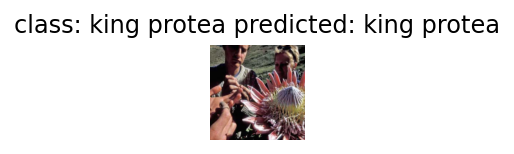

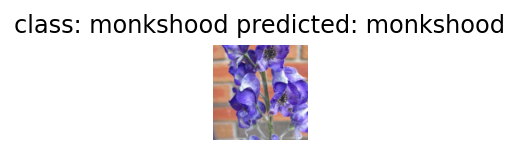

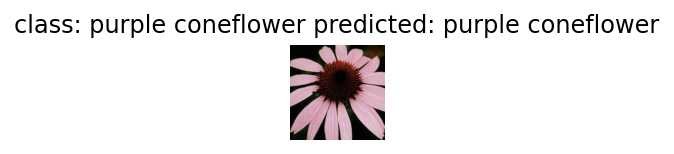

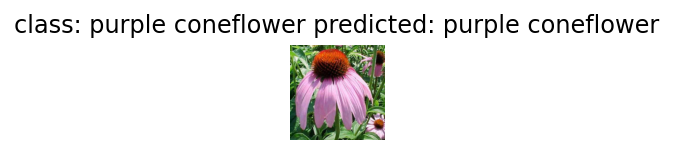

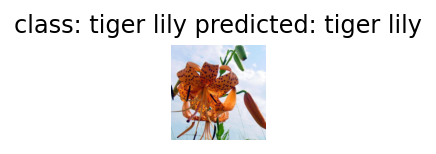

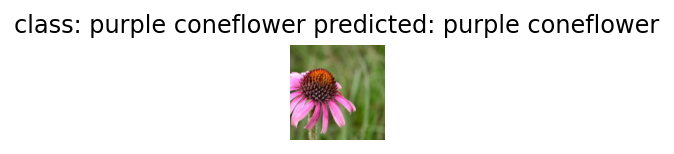

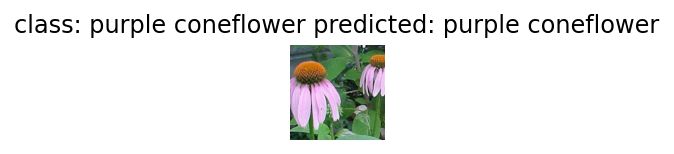

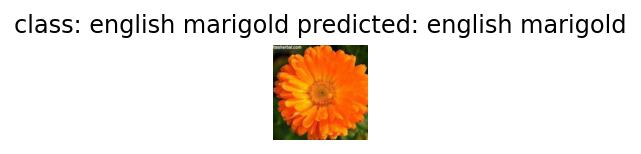

In [ ]:
# 1 resnet
visualize_model(summary_resnet)

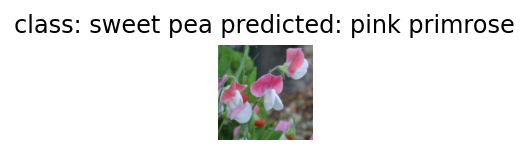

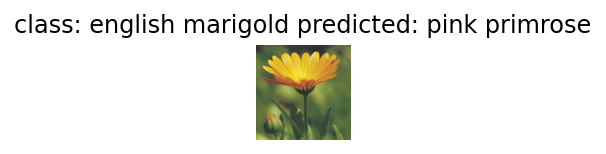

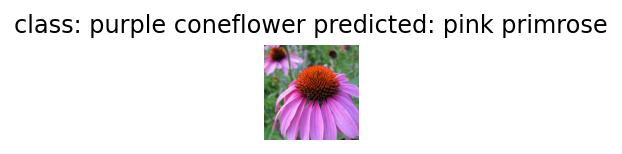

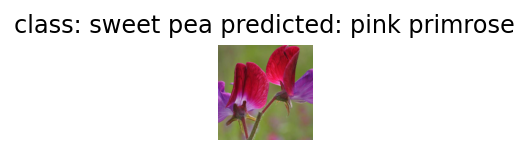

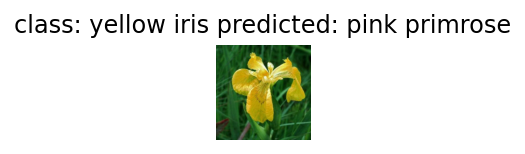

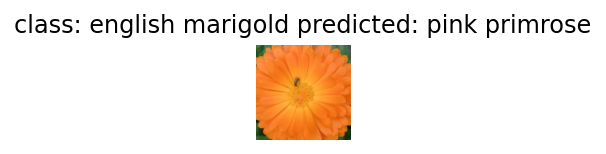

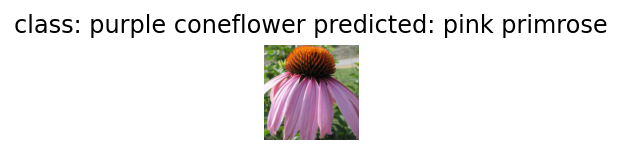

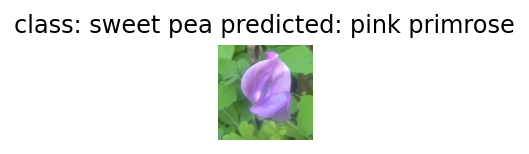

In [ ]:
# 2. vggnet
visualize_model(summary_vgg)

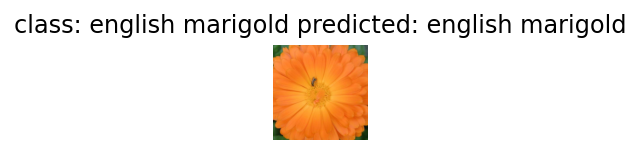

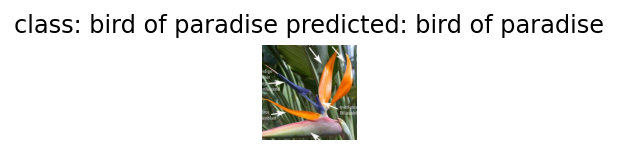

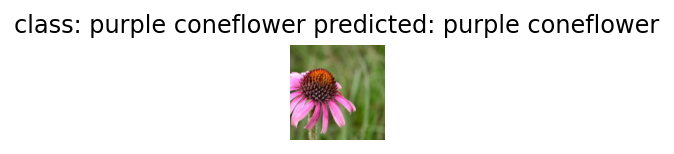

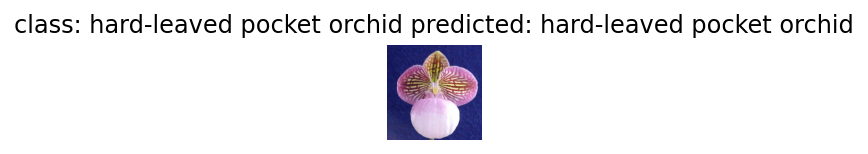

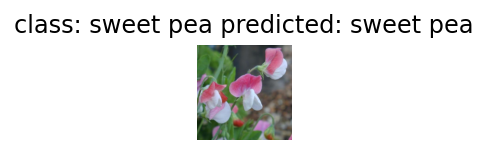

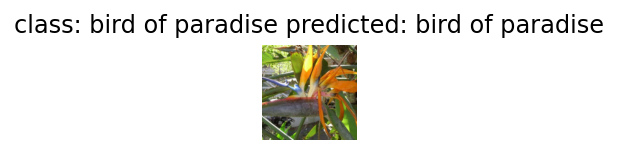

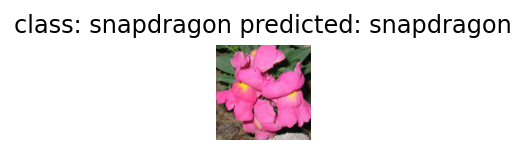

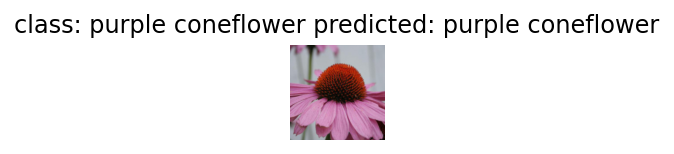

In [ ]:
# mobilev2
visualize_model(summary_mobilev2)

# Kalkulasi Model Accuracy


In [ ]:
def calc_accuracy(model, data):
    model.eval()
    if use_gpu:
      model.cuda()    
    running_corrects = 0
    test_acc = 0
    
    #with torch.no_grad():
    for idx, (inputs, labels) in enumerate(data_loader[data]):
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        # max provides the (maximum probability, max value)
        #_, predicted = outputs.max(dim=1)
        _, predicted = torch.max(outputs.data, 1)
        running_corrects += torch.sum(predicted == labels)
    test_acc = running_corrects / dataset_sizes['test']
    print('Test Accuracy: {:.4f}'.format(test_acc))

In [ ]:
# 1. Test accuracy model Resnet
calc_accuracy(summary_resnet, 'test')

Test Accuracy: 0.8947


In [ ]:
# 2. Test Accuracy model Vgg
calc_accuracy(summary_vgg,'test')

Test Accuracy: 0.0526


In [ ]:
calc_accuracy(summary_mobilev2,'test')

Test Accuracy: 0.8842


# REPORT :

Pada hasil tuning tiga backbone model (resnet 34, vgg 16, dan mobilenetv2 yang dimana dihasilkan sebuah result testing pada '`model resnet`' yang terbaik dengan akurasi sebesar '89%' di ikuti dengan mobilenev2 88% namun pada model vgg tidak menghasilkan akurasi terbaik yakni sebesar 0.52 % sangat buruk yang berarti model vgg tidak bisa mempelajari pattern pada dataset.
